In [1]:
include("../../src/Main.jl")
include("Geometry.jl")
using FerriteGmsh
using TimerOutputs
using CairoMakie
using Bessels

save_vtu = true
vtu_path = "results/"
geo_path = "geo/"

"geo/"

In [2]:
# Parameters
d = 1e-3
f = 50e3

ω = 2π * f
T = Complex{Float64}

# Generate mesh
A_cond = π / 4 * d^2
GenerateGeometryRoundWire(d, 3 * d, "geo_round_wire"; path=geo_path)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 60%] Meshing curve 3 (Circle)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.00163102s, CPU 0s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0668321s, CPU 0.078125s)
Info    : 1253 nodes 2571 elements
Info    : Writing 'geo/geo_round_wire.msh'...
Info    : Done writing 'geo/geo_round_wire.msh'


# Skin effect

In [3]:
# Simulation settings
materials = Dict(
    "Conductor" => Dict(
        "σ" => 59.6e6
    )
)

boundaries = Dict(
    "Domain" => BoundaryInfty(T)
)

Dict{String, BoundaryA{ComplexF64}} with 1 entry:
  "Domain" => BoundaryA{ComplexF64}(0.0+0.0im)

In [4]:
# Load the mesh using FerriteGmsh
grid = saved_file_to_grid(geo_path * "geo_round_wire.msh")
preprocess_grid(grid);

Info    : Reading 'geo/geo_round_wire.msh'...
Info    : 11 entities
Info    : 1252 nodes
Info    : 2502 elements
Info    : Done reading 'geo/geo_round_wire.msh'


┌ Warning: no entities added to the set with name: cells_quad
└ @ Ferrite C:\Users\gijlag\.julia\packages\Ferrite\eNNDX\src\Grid\utils.jl:4


In [5]:
problem = Problem{T}(
    symmetry=Planar2D(1),
    time=TimeHarmonic(ω),
    fe_order=2,
    qr_order=4,
    materials=materials,
    sources=Dict(),
    boundaries=boundaries
)

# Initialize FE problems and boundary constraints
cv, dh = init_problem(problem, grid)
ch = init_constraints(dh, problem)

cellparams = init_params(dh, problem)

# Circuit coupling 
cch = CircuitHandler(dh, T)
add_current_coupling!(cch, "Conductor", 1, A_cond)

# Allocate matrices for each of the simulations
K = allocate(dh, cch, problem)
K, f = assemble_global(K, dh, cv, problem, cellparams)

# Apply the boundary constraints
apply_circuit_couplings!(problem, problem.time, cellparams, K, f, cv, dh, cch)
apply!(K, f, ch)

In [6]:
# Solve the linear systems
u = K \ f;

In [7]:
# Post-processing
B = ComputeFluxDensity(dh, cv, u, problem, cellparams)
J = ComputeCurrentDensity(dh, cv, cch, u, problem, cellparams)
#S = ComputeLossDensity(dh, cv, J, B, problem, cellparams)

(I_circ, S_circ, R_circ) = ComputeLoss(dh, cv, cch, J, B, problem, cellparams)

VTKGridFile(vtu_path * "round_wire_skin", dh; write_discontinuous=true) do vtk
    write_postprocessed(vtk, dh, cch, u, problem, cellparams, :B_norm, "B_norm")
    write_postprocessed(vtk, dh, cch, u, problem, cellparams, :J_norm, "J_norm")
end

VTKGridFile for the closed file "results/round_wire_skin.vtu".

In [8]:
Rac = R_circ[1]
Rdc = problem.symmetry.depth / (A_cond * materials["Conductor"]["σ"])
F = Rac / Rdc

1.15921745242711

## Frequency sweep

In [9]:
f_list = 10 .^ range(log10(1e3), log10(1e6), 20)
ω_list = 2π * f_list

Rac = zeros(size(ω_list))
Acond = zeros(size(ω_list))

# Loop through the frequencies
for (i, ω) ∈ enumerate(ω_list)
    println("Run $i of $(size(ω_list, 1)): f = $(f_list[i]) Hz")

    problem = Problem{T}(
        symmetry=Planar2D(1),
        time=TimeHarmonic(ω),
        fe_order=2,
        qr_order=4,
        materials=materials,
        sources=Dict(),
        boundaries=boundaries
    )

    # Initialize FE problems and boundary constraints
    cv, dh = init_problem(problem, grid)
    ch = init_constraints(dh, problem)

    cellparams = init_params(dh, problem)

    # Circuit coupling 
    cch = CircuitHandler(dh, T)
    add_current_coupling!(cch, "Conductor", 1, A_cond)

    # Allocate matrices for each of the simulations
    K = allocate(dh, cch, problem)
    K, f = assemble_global(K, dh, cv, problem, cellparams)

    # Apply the boundary constraints
    apply_circuit_couplings!(problem, problem.time, cellparams, K, f, cv, dh, cch)
    apply!(K, f, ch)

    # Solve the linear systems
    u = K \ f

    # Post-processing
    B = ComputeFluxDensity(dh, cv, u, problem, cellparams)
    J = ComputeCurrentDensity(dh, cv, cch, u, problem, cellparams)

    (I_circ, S_circ, R_circ, A_circ) = ComputeLoss(dh, cv, cch, J, B, problem, cellparams)

    Rac[i] = R_circ[1]
    Acond[i] = A_circ[1]

    if (save_vtu)
        VTKGridFile(vtu_path * "round_wire_skin_$i", dh; write_discontinuous=true) do vtk
            write_postprocessed(vtk, dh, cch, u, problem, cellparams, :B_norm, "B_norm")
            write_postprocessed(vtk, dh, cch, u, problem, cellparams, :J_norm, "J_norm")
        end
    end
end

Run 1 of 20: f = 1000.0 Hz
Run 2 of 20: f = 1438.449888287663 Hz
Run 3 of 20: f = 2069.13808111479 Hz
Run 4 of 20: f = 2976.351441631319 Hz
Run 5 of 20: f = 4281.332398719395 Hz
Run 6 of 20: f = 6158.48211066026 Hz
Run 7 of 20: f = 8858.667904100823 Hz
Run 8 of 20: f = 12742.749857031347 Hz
Run 9 of 20: f = 18329.807108324374 Hz
Run 10 of 20: f = 26366.50898730361 Hz
Run 11 of 20: f = 37926.90190732246 Hz
Run 12 of 20: f = 54555.947811685146 Hz
Run 13 of 20: f = 78475.99703514607 Hz
Run 14 of 20: f = 112883.78916846884 Hz
Run 15 of 20: f = 162377.67391887208 Hz
Run 16 of 20: f = 233572.14690901214 Hz
Run 17 of 20: f = 335981.8286283781 Hz
Run 18 of 20: f = 483293.0238571752 Hz
Run 19 of 20: f = 695192.7961775606 Hz
Run 20 of 20: f = 1.0e6 Hz


In [10]:
σ = materials["Conductor"]["σ"]

# FEM AC resistance factor
Rdc = 1 / (σ * Acond[1])
F = Rac / Rdc;

# Analytical AC resistance factor
μ0 = 4π * 1e-7
δ = 1 ./ sqrt.(π * μ0 * σ * f_list)
k = (1 + 1im) ./ δ
Fa = real.(0.25 * d * k .* besselj0.(k * d / 2) ./ besselj1.(k * d / 2));

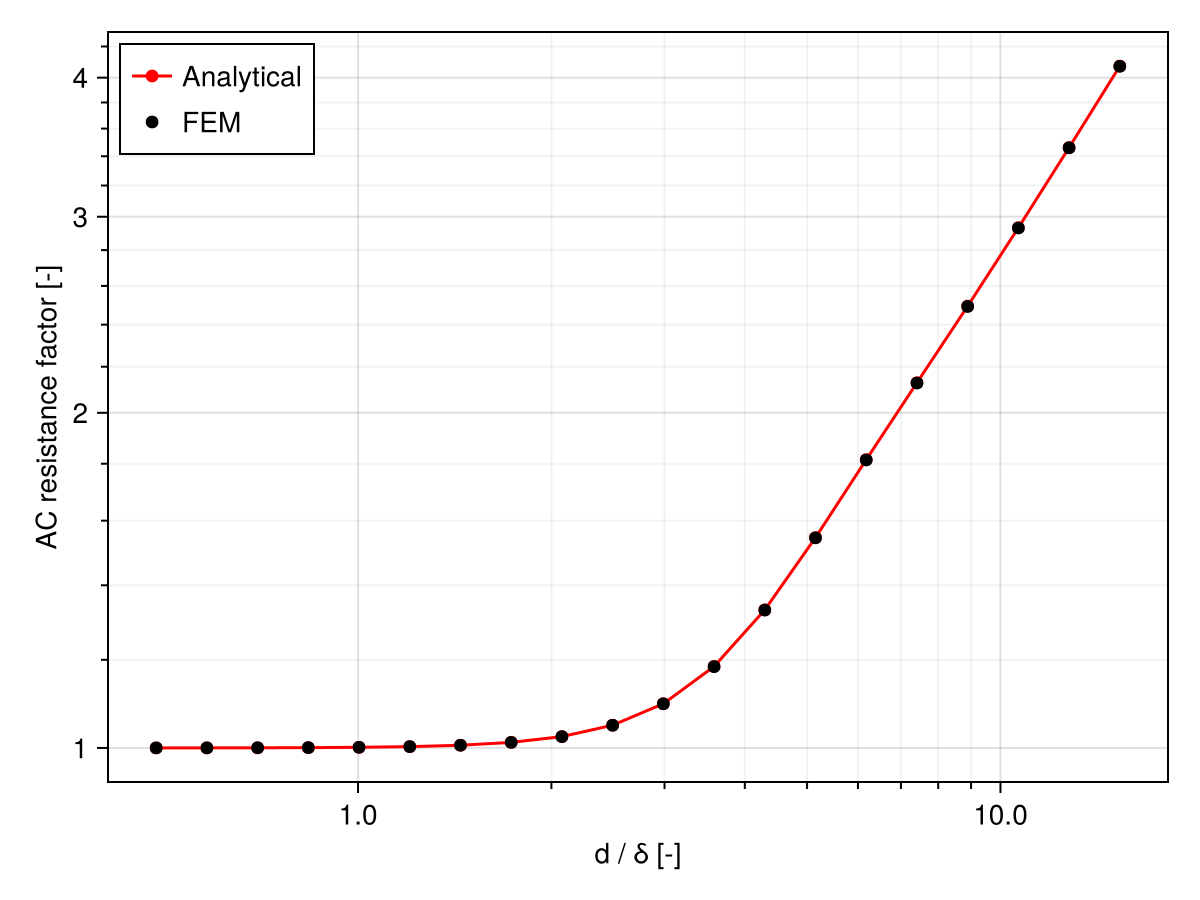

In [11]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="d / δ [-]", ylabel="AC resistance factor [-]",
    xticks=[0.1, 1, 10], yticks=[1, 2, 3, 4, 5],
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    yminorticksvisible=true, yminorgridvisible=true, yminorticks=IntervalsBetween(5),
    xscale=log10, yscale=log10
)

scatterlines!(ax, d ./ δ, Fa, color=:red, label="Analytical")
scatter!(ax, d ./ δ, F, color=:black, label="FEM")
axislegend(position=:lt)

fig

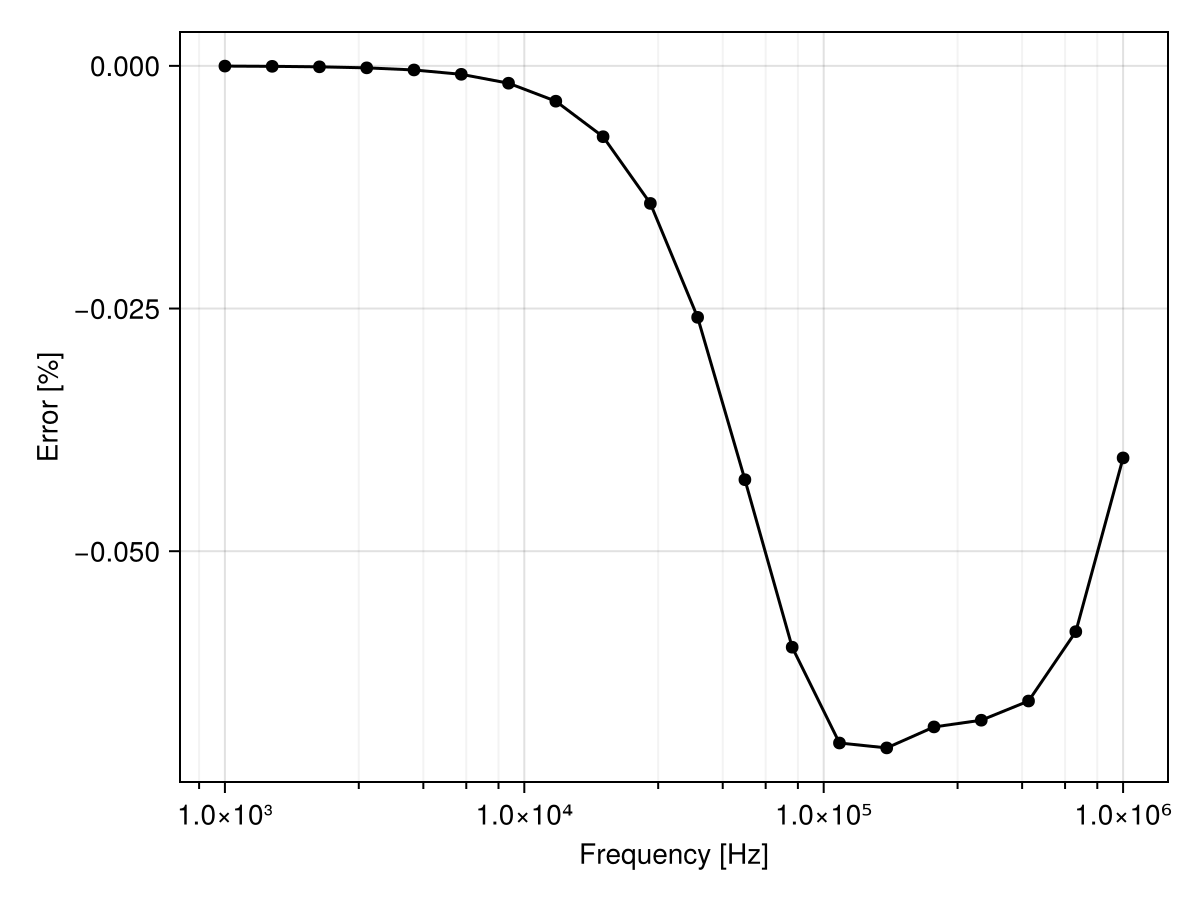

In [12]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Frequency [Hz]", ylabel="Error [%]",
    xticks = [1e3, 10e3, 100e3, 1e6],
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    xscale=log10
)

scatterlines!(ax, f_list, (F - Fa) ./ Fa * 1e2, color=:black)

fig
     